In [1]:
import numpy as np
import pandas as pd

In [219]:
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

# Config

In [226]:
random_state = 1291

feature_cols = ["PC", "RA", "SA1", "FiringRate_value","Spikes_diff_mean", "depth", "Pin_Radius", "Spikes_diff_time_inrange", "Spikes_n_items"][-2:] 
feature_cols = ["PC", "RA", "SA1", "FiringRate_value","Spikes_diff_mean", "Pin_Radius", "Spikes_diff_time_inrange",
               "Spikes_diff_mean_2","Spikes_diff_mean_5"] #"depth"
# feature_cols = ["Spikes_diff_time_inrange","FiringRate_value"]
target_col = "Frequency"

N_folds = 5

# Load Data

In [204]:
dataset = pd.read_csv("../data/dataset_v2.csv", index_col=0)
print(dataset.shape)
dataset.sample(5)

(10860, 15)


,PC,PC.1,RA,RA.1,SA1,SA1.1,FiringRate_value,Spikes_n_items,Spikes_diff_mean,depth,Pin_Radius,Spikes_diff_time_inrange,Spikes_diff_mean_2,Spikes_diff_mean_5,Frequency
146,1,1,0,0,0,0,95.40,189,0.021033,1.28,0.960,0.1032,0.021033,0.052603,95
7194,1,1,0,0,0,0,164.20,265,0.011934,1.70,0.790,0.0812,0.011934,0.029576,85
8633,1,1,0,0,0,0,166.80,178,0.011784,1.07,1.185,0.0636,0.011784,0.029422,85
1783,1,1,0,0,0,0,35.22,37,0.054514,1.99,1.420,0.2722,0.054514,0.136313,55
9488,0,0,1,1,0,0,26.62,34,0.070688,1.51,0.480,0.3724,0.070688,0.175552,35


# Split

In [205]:
X, y = dataset[feature_cols], dataset[target_col]
X.shape, y.shape

((10860, 9), (10860,))

In [246]:
skf = StratifiedKFold(random_state=random_state)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    dataset[f"fold_{i}"] = ""
    dataset.loc[train_index, f"fold_{i}"] = "train"
    dataset.loc[test_index, f"fold_{i}"] = "test"

/home/minesh_1291/anaconda3/envs/noaa-runtime/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


# Model

In [247]:
# BaggingClassifier - ElasticNetCV

enet = ElasticNetCV(
    l1_ratio=0.5,
    eps=0.001,
    n_alphas=100,
    random_state=random_state,
    fit_intercept=True)

bagging = BaggingRegressor(enet,
                           n_estimators=100,
                            max_samples=0.5, max_features=0.5)


In [252]:
# RandomForestClassifier

rfc = RandomForestClassifier(
    min_samples_split=25)

In [253]:
# ElasticNetCV

# enet = ElasticNetCV(
#     l1_ratio=0.5,
#     eps=0.001,
#     n_alphas=100,
#     random_state=random_state,
#     fit_intercept=True)

In [254]:
for f in range(N_folds):
    print(f"fold_{f}")
    X_tr, y_tr = dataset.loc[dataset[f"fold_{f}"]=="train",feature_cols], dataset.loc[dataset[f"fold_{f}"]=="train", target_col]
    X_test, y_test = dataset.loc[dataset[f"fold_{f}"]=="test",feature_cols], dataset.loc[dataset[f"fold_{f}"]=="test", target_col]
    
    rfc = rfc.fit(X_tr, y_tr)
    print(
        rfc.score(X_tr, y_tr),
        rfc.score(X_test, y_test)
    )
    
    dataset.loc[dataset[f"fold_{f}"]=="train", f"fold_{f}_pred"] = rfc.predict(X_tr)
    dataset.loc[dataset[f"fold_{f}"]=="test", f"fold_{f}_pred"] = rfc.predict(X_test)
    
    

fold_0
0.819866482504604 0.6998158379373849
fold_1
0.8105432780847146 0.7076427255985267
fold_2
0.8107734806629834 0.7021178637200737
fold_3
0.8154926335174953 0.6979742173112339
fold_4
0.815377532228361 0.7168508287292817


In [209]:
# ElasticNetCV

# enet.score(X,y)

In [251]:
# BaggingClassifier - ElasticNetCV

# bagging.score(X, y)

rfc.score(X, y)

0.868232044198895

# Evaluate

In [215]:
pred_y = rfc.predict(X)

/home/minesh_1291/anaconda3/envs/noaa-runtime/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Frequency'>

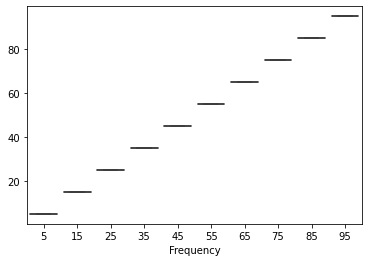

In [216]:
sns.boxplot(y, pred_y) # ,".")

In [217]:
r2_score(y, pred_y)

1.0

<ipython-input-218-8f93844441e9>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rmse_dict = pd.Series(index=freqs)


<AxesSubplot:>

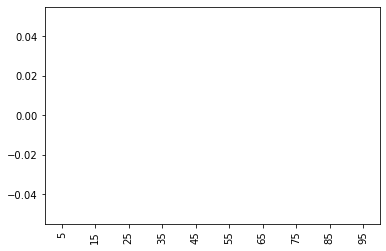

In [218]:
def rmse_f(y, y_):
    rmse = mean_squared_error(y, y_, squared=False)
    return round(rmse, 3)

freqs = np.sort(y.unique())
rmse_dict = pd.Series(index=freqs)
for yi in freqs:
    rmse_dict[yi] = rmse_f(y[y==yi], pred_y[y==yi])
    
rmse_dict.plot(kind='bar')

In [237]:
dataset["Afferent_Class"] = dataset[["PC", "RA", "SA1"]].idxmax(1)

In [243]:
dataset.groupby(["Afferent_Class","Frequency"])["fold_1"].value_counts().sort_index()

Afferent_Class  Frequency  fold_1
PC              5          test        2
                           train       8
                15         test       76
                           train     297
                25         test      111
                           train     435
                35         test      148
                           train     568
                45         test      142
                           train     532
                55         test      163
                           train     614
                65         test      154
                           train     643
                75         test      174
                           train     610
                85         test      168
                           train     698
                95         test      169
                           train     662
RA              5          test       21
                           train      84
                15         test       50
                       

# Interpretation

## RFC

## Enet

In [145]:
enet.alpha_

1.4060874177665517

In [146]:
enet.l1_ratio_

0.5

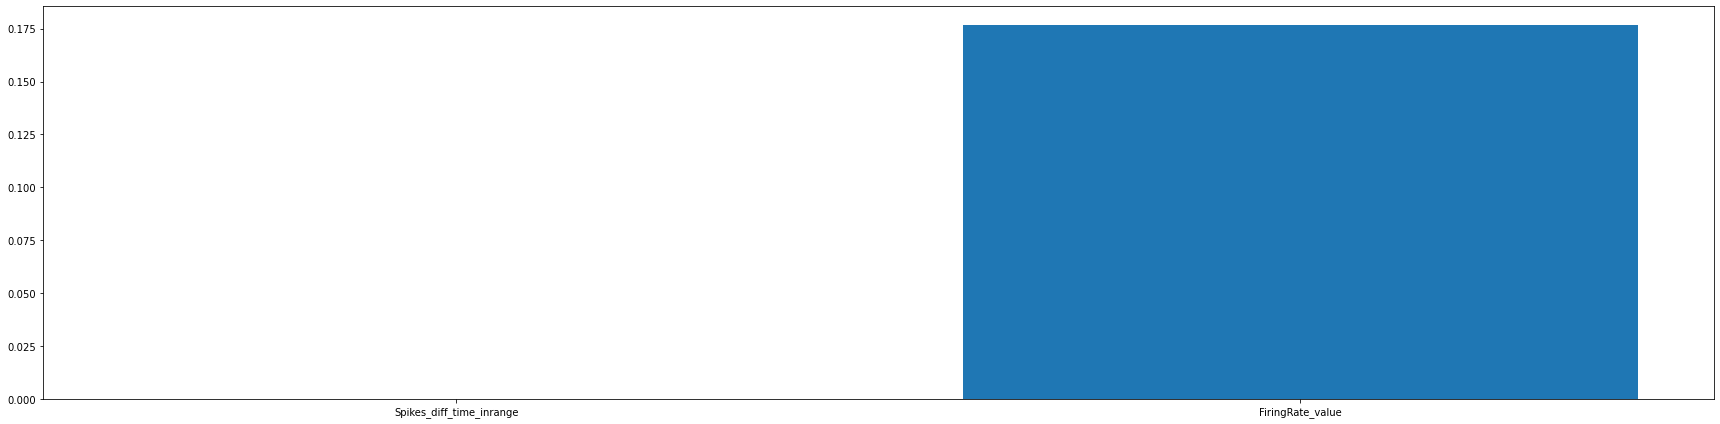

In [147]:
plt.subplots(figsize=(24,6))
plt.bar(feature_cols, enet.coef_)
plt.tight_layout()